****MAE 250A HW 6****
<br>****David Tran****

In [1]:
using FluidDynTools
using PotentialFlow
using PotentialFlow.Bodies
import PotentialFlow: Polygon
using Plots

## 10 Degrees

In [2]:
c = 1.0
p = Polygon([-0.5c,0.5c],[0.0,0.0])
Zr = 0.0+0.0im
α = -10*π/180
b = ConformalBody(p,Zr,α)

Body generated by: Schwarz-Christoffel map of unit circle to exterior of polygon with 2 vertices

  centroid at 0.0 + 0.0im
  angle -0.1745


In [3]:
xlim=(-2,2)
ylim=(-1,1)
xg = range(xlim...,length=201)
yg = range(ylim...,length=51)
zg = [x + im*y for y in yg, x in xg]
ζg = inverse_conftransform(zg,b);

In [5]:
t = 0.0
motion = RigidBodyMotion(0.0, 0.0)
Winf = 1.0 + 0.0im
fs = Freestreams.Freestream(conj(Winf))
sys = (fs,)
sys = inverse_conftransform(sys,b)

clear_images!(b)
enforce_no_flow_through!(b, motion, sys, t)

function compute_ẋ!(ẋ, x, t)
    body, ambient_sys = x
    motion = ẋ[1]
    # update the instantaneous motion of the body with the current motion
    motion.ċ, motion.c̈, motion.α̇, motion.α̈ = motion.kin(t)

    enforce_no_flow_through!(body, motion, ambient_sys, t)

    # Zero the velocity
    reset_velocity!(ẋ, x)

    # Compute the self-induced velocity of the system
    self_induce_velocity!(ẋ, x, t)

    # Modify the velocity so that it provides the rate of change in the circle plane.
    transform_velocity!(ẋ, ẋ, x, body)
end

function shed_new_vorticity!(blobs, edge1, edge2, body, motion, t, spcrit1 = 0.0, spcrit2 = 0.0)
    # edge1 and edge2 specify the indices of edge points on the body

    ϕ = 1/3 # fractional distance from the edge point to the previous blob

    # Location edges in physical plane
    zedge1 = body.zs[edge1]
    zedge2 = body.zs[edge2]

    # positions of previously-released blobs, transformed to physical plane
    zblob1 = conftransform(blobs[end-1].z,body)
    zblob2 = conftransform(blobs[end].z,body)

    # positions of new blobs in physical plane
    z1 = ϕ*zblob1 + (1-ϕ)*zedge1
    z2 = ϕ*zblob2 + (1-ϕ)*zedge2

    # positions of new blobs in circle plane
    ζ1 = inverse_conftransform(z1,body)
    ζ2 = inverse_conftransform(z2,body)

    # new blobs, with unit strength for now
    blob1 = Vortex.Blob(ζ1, 1.0, δ)
    blob2 = Vortex.Blob(ζ2, 1.0, δ)

    enforce_no_flow_through!(body, motion, blobs, t)

    # Determine the strengths of the new blobs
    Γ1, Γ2 = Bodies.vorticity_flux(body, edge1, edge2, (body,blobs), [blob1], [blob2], t, spcrit1, spcrit2);

    # Add the new blobs to the list
    push!(blobs, Vortex.Blob(ζ1, Γ1, blobs[1].δ), Vortex.Blob(ζ2, Γ2, blobs[1].δ))

end

Δt = 5e-3
b = ConformalBody(p,Zr,α)
Żr = -1.0 + 0.0im
motion = RigidBodyMotion(Żr,0.0)


# critical edge suction parameters
spcrit1 = Inf # leading edge. Make this Inf if you want to suppress vortex shedding from the leading edge.
spcrit2 = 0 # trailing edge

kLE, kTE = 1, 2

# Nothing to change below this line

# blob radius
δ = 0.02

# locations of edges in physical plane
zedge1, zedge2 = b.zs[[kLE,kTE]]

# Vector to add to these edges. This determines the initial placement of the
# first vortex elements relative to the edges.
# Δz₀ = -3*im*Δt*exp(-im*b.α)
Δz₀ = [-3*Δt*exp(im*b.α),3*Δt*exp(im*b.α)]


# locations of initial blobs in circle plane
ζblob = inverse_conftransform(Δz₀ .+ [zedge1, zedge2],b)

# create the initial two blobs, for now with unit strength
blobs = Vortex.Blob.(ζblob, 1.0, δ)

enforce_no_flow_through!(b, motion, (), 0.0)
sys = (b,)

# This determines the circulations that enforce the edge conditions
Γ1, Γ2 = Bodies.vorticity_flux(b, kLE, kTE, sys, [blobs[1]], [blobs[2]], 0, spcrit1, spcrit2);

# Now create the blobs with the correct circulations
blobs = Vortex.Blob.(ζblob, [Γ1, Γ2], δ)

# This creates the image blobs, so that no-penetration condition is enforced
enforce_no_flow_through!(b, motion, blobs, 0.0)

# Set up the initial system
ambient_sys = blobs

t = 0.0
sys = (b, ambient_sys)
sys₊ = deepcopy(sys) # Used for storage during time-marching
nothing

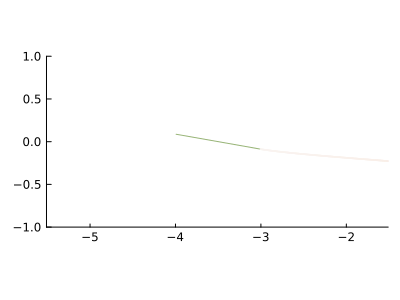

In [10]:
ẋs = (motion, allocate_velocity(ambient_sys))
time = Float64[]
imp = ComplexF64[]
blob_z = conftransform(ambient_sys,b)
track = [deepcopy((b,blob_z))]
push!(imp,Elements.impulse((b,blob_z)))
tsamp = 0.25 # Rate at which to save system data in `track` array
nothing

tf = 3.0
for tloc in 0:Δt:tf
    b_now, ambient_ω_ζ = sys

    resize!(sys₊[2], length(sys[2]))
    TimeMarching.forward_euler!(sys₊, sys, t, Δt, compute_ẋ!, advect!, ẋs)

    global sys₊, sys = sys, sys₊

    global t += Δt

    shed_new_vorticity!(sys[2], kLE, kTE, sys[1], ẋs[1], t, spcrit1, spcrit2)

    # save stuff
    push!(time,t)
    b_now, ambient_ω_ζ = deepcopy(sys)
    global blob_z = conftransform(ambient_ω_ζ,b_now)

    if abs(mod(t,tsamp))<1e-8 || abs(mod(t,tsamp)-tsamp)<1e-8
        push!(track,deepcopy((b_now,blob_z)))
    end

    enforce_no_flow_through!(b_now, motion, ambient_ω_ζ, t)
    push!(imp,Elements.impulse((b_now,blob_z)))

end
b_now, ambient_ω_ζ = sys
blob_z = conftransform(ambient_ω_ζ,b_now);

xlim = (-2-time[end],2-time[end])
ylim = (-1,1)
ps = plot(track[end],legend=false,markerstrokewidth=0,color=cgrad(:RdBu,rev=true),clim=(-0.025/(2π),0.025/(2π)),markersize=1,ratio=1,xlim=xlim,ylim=ylim) #

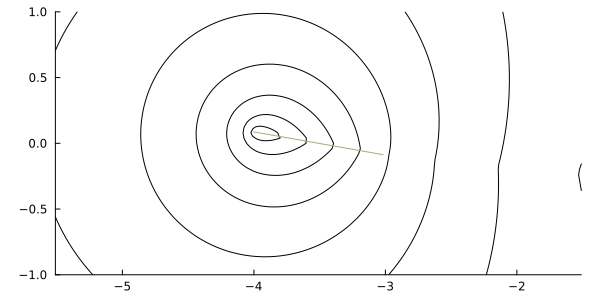

In [11]:
xg = range(xlim...,length=201)
yg = range(ylim...,length=51)
zg = [x + im*y for y in yg, x in xg]
ζg = inverse_conftransform(zg,b)
ps = streamlines(xg,yg,ζg,(b,sys),levels=range(-1,1,length=31),xlim=xlim,ylim=ylim)
plot!(ps,b,size=(600,300))

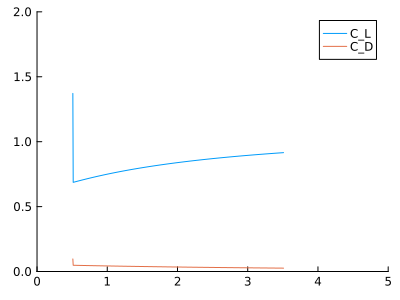

In [12]:
fhist = -diff(imp)/Δt
plot(time,2*imag.(fhist),label="C_L",xlim=(0,5),ylim=(0,2),legend=true)
plot!(time,2*real.(fhist),label="C_D")

## 20 Degrees

In [13]:
c = 1.0
p = Polygon([-0.5c,0.5c],[0.0,0.0])
Zr = 0.0+0.0im
α = -20*π/180
b = ConformalBody(p,Zr,α)

Body generated by: Schwarz-Christoffel map of unit circle to exterior of polygon with 2 vertices

  centroid at 0.0 + 0.0im
  angle -0.3491


In [14]:
xlim=(-2,2)
ylim=(-1,1)
xg = range(xlim...,length=201)
yg = range(ylim...,length=51)
zg = [x + im*y for y in yg, x in xg]
ζg = inverse_conftransform(zg,b);

In [15]:
t = 0.0
motion = RigidBodyMotion(0.0, 0.0)
Winf = 1.0 + 0.0im
fs = Freestreams.Freestream(conj(Winf))
sys = (fs,)
sys = inverse_conftransform(sys,b)

clear_images!(b)
enforce_no_flow_through!(b, motion, sys, t)

function compute_ẋ!(ẋ, x, t)
    body, ambient_sys = x
    motion = ẋ[1]
    # update the instantaneous motion of the body with the current motion
    motion.ċ, motion.c̈, motion.α̇, motion.α̈ = motion.kin(t)

    enforce_no_flow_through!(body, motion, ambient_sys, t)

    # Zero the velocity
    reset_velocity!(ẋ, x)

    # Compute the self-induced velocity of the system
    self_induce_velocity!(ẋ, x, t)

    # Modify the velocity so that it provides the rate of change in the circle plane.
    transform_velocity!(ẋ, ẋ, x, body)
end

function shed_new_vorticity!(blobs, edge1, edge2, body, motion, t, spcrit1 = 0.0, spcrit2 = 0.0)
    # edge1 and edge2 specify the indices of edge points on the body

    ϕ = 1/3 # fractional distance from the edge point to the previous blob

    # Location edges in physical plane
    zedge1 = body.zs[edge1]
    zedge2 = body.zs[edge2]

    # positions of previously-released blobs, transformed to physical plane
    zblob1 = conftransform(blobs[end-1].z,body)
    zblob2 = conftransform(blobs[end].z,body)

    # positions of new blobs in physical plane
    z1 = ϕ*zblob1 + (1-ϕ)*zedge1
    z2 = ϕ*zblob2 + (1-ϕ)*zedge2

    # positions of new blobs in circle plane
    ζ1 = inverse_conftransform(z1,body)
    ζ2 = inverse_conftransform(z2,body)

    # new blobs, with unit strength for now
    blob1 = Vortex.Blob(ζ1, 1.0, δ)
    blob2 = Vortex.Blob(ζ2, 1.0, δ)

    enforce_no_flow_through!(body, motion, blobs, t)

    # Determine the strengths of the new blobs
    Γ1, Γ2 = Bodies.vorticity_flux(body, edge1, edge2, (body,blobs), [blob1], [blob2], t, spcrit1, spcrit2);

    # Add the new blobs to the list
    push!(blobs, Vortex.Blob(ζ1, Γ1, blobs[1].δ), Vortex.Blob(ζ2, Γ2, blobs[1].δ))

end

Δt = 5e-3
b = ConformalBody(p,Zr,α)
Żr = -1.0 + 0.0im
motion = RigidBodyMotion(Żr,0.0)


# critical edge suction parameters
spcrit1 = Inf # leading edge. Make this Inf if you want to suppress vortex shedding from the leading edge.
spcrit2 = 0 # trailing edge

kLE, kTE = 1, 2

# Nothing to change below this line

# blob radius
δ = 0.02

# locations of edges in physical plane
zedge1, zedge2 = b.zs[[kLE,kTE]]

# Vector to add to these edges. This determines the initial placement of the
# first vortex elements relative to the edges.
# Δz₀ = -3*im*Δt*exp(-im*b.α)
Δz₀ = [-3*Δt*exp(im*b.α),3*Δt*exp(im*b.α)]


# locations of initial blobs in circle plane
ζblob = inverse_conftransform(Δz₀ .+ [zedge1, zedge2],b)

# create the initial two blobs, for now with unit strength
blobs = Vortex.Blob.(ζblob, 1.0, δ)

enforce_no_flow_through!(b, motion, (), 0.0)
sys = (b,)

# This determines the circulations that enforce the edge conditions
Γ1, Γ2 = Bodies.vorticity_flux(b, kLE, kTE, sys, [blobs[1]], [blobs[2]], 0, spcrit1, spcrit2);

# Now create the blobs with the correct circulations
blobs = Vortex.Blob.(ζblob, [Γ1, Γ2], δ)

# This creates the image blobs, so that no-penetration condition is enforced
enforce_no_flow_through!(b, motion, blobs, 0.0)

# Set up the initial system
ambient_sys = blobs

t = 0.0
sys = (b, ambient_sys)
sys₊ = deepcopy(sys) # Used for storage during time-marching
nothing

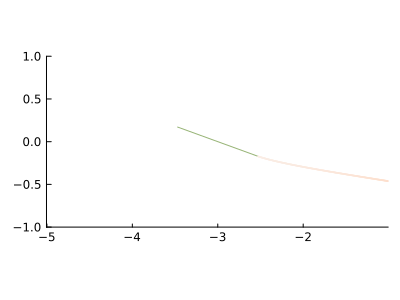

In [16]:
ẋs = (motion, allocate_velocity(ambient_sys))
time = Float64[]
imp = ComplexF64[]
blob_z = conftransform(ambient_sys,b)
track = [deepcopy((b,blob_z))]
push!(imp,Elements.impulse((b,blob_z)))
tsamp = 0.25 # Rate at which to save system data in `track` array
nothing

tf = 3.0
for tloc in 0:Δt:tf
    b_now, ambient_ω_ζ = sys

    resize!(sys₊[2], length(sys[2]))
    TimeMarching.forward_euler!(sys₊, sys, t, Δt, compute_ẋ!, advect!, ẋs)

    global sys₊, sys = sys, sys₊

    global t += Δt

    shed_new_vorticity!(sys[2], kLE, kTE, sys[1], ẋs[1], t, spcrit1, spcrit2)

    # save stuff
    push!(time,t)
    b_now, ambient_ω_ζ = deepcopy(sys)
    global blob_z = conftransform(ambient_ω_ζ,b_now)

    if abs(mod(t,tsamp))<1e-8 || abs(mod(t,tsamp)-tsamp)<1e-8
        push!(track,deepcopy((b_now,blob_z)))
    end

    enforce_no_flow_through!(b_now, motion, ambient_ω_ζ, t)
    push!(imp,Elements.impulse((b_now,blob_z)))

end
b_now, ambient_ω_ζ = sys
blob_z = conftransform(ambient_ω_ζ,b_now);

xlim = (-2-time[end],2-time[end])
ylim = (-1,1)
ps = plot(track[end],legend=false,markerstrokewidth=0,color=cgrad(:RdBu,rev=true),clim=(-0.025/(2π),0.025/(2π)),markersize=1,ratio=1,xlim=xlim,ylim=ylim) #

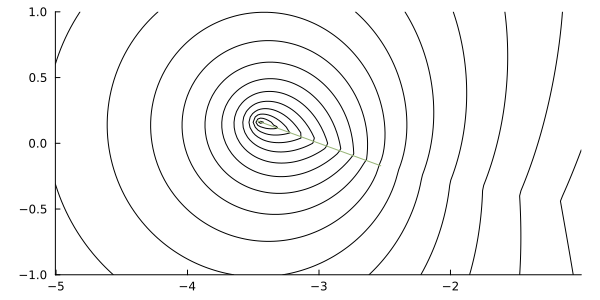

In [17]:
xg = range(xlim...,length=201)
yg = range(ylim...,length=51)
zg = [x + im*y for y in yg, x in xg]
ζg = inverse_conftransform(zg,b)
ps = streamlines(xg,yg,ζg,(b,sys),levels=range(-1,1,length=31),xlim=xlim,ylim=ylim)
plot!(ps,b,size=(600,300))

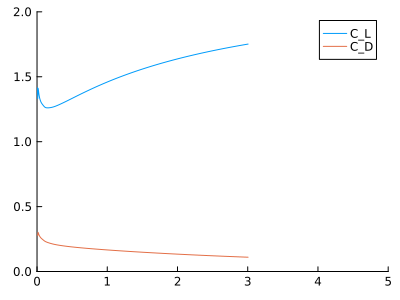

In [18]:
fhist = -diff(imp)/Δt
plot(time,2*imag.(fhist),label="C_L",xlim=(0,5),ylim=(0,2),legend=true)
plot!(time,2*real.(fhist),label="C_D")

## 40 degrees with spcrit1 = Inf

In [22]:
c = 1.0
p = Polygon([-0.5c,0.5c],[0.0,0.0])
Zr = 0.0+0.0im
α = -40*π/180
b = ConformalBody(p,Zr,α)

Body generated by: Schwarz-Christoffel map of unit circle to exterior of polygon with 2 vertices

  centroid at 0.0 + 0.0im
  angle -0.6981


In [23]:
xlim=(-2,2)
ylim=(-1,1)
xg = range(xlim...,length=201)
yg = range(ylim...,length=51)
zg = [x + im*y for y in yg, x in xg]
ζg = inverse_conftransform(zg,b);

In [24]:
t = 0.0
motion = RigidBodyMotion(0.0, 0.0)
Winf = 1.0 + 0.0im
fs = Freestreams.Freestream(conj(Winf))
sys = (fs,)
sys = inverse_conftransform(sys,b)

clear_images!(b)
enforce_no_flow_through!(b, motion, sys, t)

function compute_ẋ!(ẋ, x, t)
    body, ambient_sys = x
    motion = ẋ[1]
    # update the instantaneous motion of the body with the current motion
    motion.ċ, motion.c̈, motion.α̇, motion.α̈ = motion.kin(t)

    enforce_no_flow_through!(body, motion, ambient_sys, t)

    # Zero the velocity
    reset_velocity!(ẋ, x)

    # Compute the self-induced velocity of the system
    self_induce_velocity!(ẋ, x, t)

    # Modify the velocity so that it provides the rate of change in the circle plane.
    transform_velocity!(ẋ, ẋ, x, body)
end

function shed_new_vorticity!(blobs, edge1, edge2, body, motion, t, spcrit1 = 0.0, spcrit2 = 0.0)
    # edge1 and edge2 specify the indices of edge points on the body

    ϕ = 1/3 # fractional distance from the edge point to the previous blob

    # Location edges in physical plane
    zedge1 = body.zs[edge1]
    zedge2 = body.zs[edge2]

    # positions of previously-released blobs, transformed to physical plane
    zblob1 = conftransform(blobs[end-1].z,body)
    zblob2 = conftransform(blobs[end].z,body)

    # positions of new blobs in physical plane
    z1 = ϕ*zblob1 + (1-ϕ)*zedge1
    z2 = ϕ*zblob2 + (1-ϕ)*zedge2

    # positions of new blobs in circle plane
    ζ1 = inverse_conftransform(z1,body)
    ζ2 = inverse_conftransform(z2,body)

    # new blobs, with unit strength for now
    blob1 = Vortex.Blob(ζ1, 1.0, δ)
    blob2 = Vortex.Blob(ζ2, 1.0, δ)

    enforce_no_flow_through!(body, motion, blobs, t)

    # Determine the strengths of the new blobs
    Γ1, Γ2 = Bodies.vorticity_flux(body, edge1, edge2, (body,blobs), [blob1], [blob2], t, spcrit1, spcrit2);

    # Add the new blobs to the list
    push!(blobs, Vortex.Blob(ζ1, Γ1, blobs[1].δ), Vortex.Blob(ζ2, Γ2, blobs[1].δ))

end

Δt = 5e-3
b = ConformalBody(p,Zr,α)
Żr = -1.0 + 0.0im
motion = RigidBodyMotion(Żr,0.0)


# critical edge suction parameters
spcrit1 = Inf # leading edge. Make this Inf if you want to suppress vortex shedding from the leading edge.
spcrit2 = 0 # trailing edge

kLE, kTE = 1, 2

# Nothing to change below this line

# blob radius
δ = 0.02

# locations of edges in physical plane
zedge1, zedge2 = b.zs[[kLE,kTE]]

# Vector to add to these edges. This determines the initial placement of the
# first vortex elements relative to the edges.
# Δz₀ = -3*im*Δt*exp(-im*b.α)
Δz₀ = [-3*Δt*exp(im*b.α),3*Δt*exp(im*b.α)]


# locations of initial blobs in circle plane
ζblob = inverse_conftransform(Δz₀ .+ [zedge1, zedge2],b)

# create the initial two blobs, for now with unit strength
blobs = Vortex.Blob.(ζblob, 1.0, δ)

enforce_no_flow_through!(b, motion, (), 0.0)
sys = (b,)

# This determines the circulations that enforce the edge conditions
Γ1, Γ2 = Bodies.vorticity_flux(b, kLE, kTE, sys, [blobs[1]], [blobs[2]], 0, spcrit1, spcrit2);

# Now create the blobs with the correct circulations
blobs = Vortex.Blob.(ζblob, [Γ1, Γ2], δ)

# This creates the image blobs, so that no-penetration condition is enforced
enforce_no_flow_through!(b, motion, blobs, 0.0)

# Set up the initial system
ambient_sys = blobs

t = 0.0
sys = (b, ambient_sys)
sys₊ = deepcopy(sys) # Used for storage during time-marching
nothing

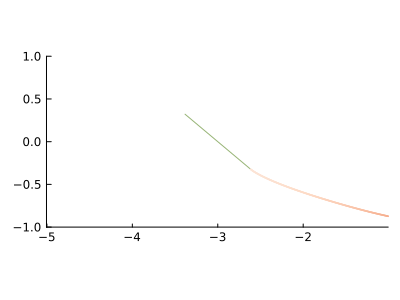

In [25]:
ẋs = (motion, allocate_velocity(ambient_sys))
time = Float64[]
imp = ComplexF64[]
blob_z = conftransform(ambient_sys,b)
track = [deepcopy((b,blob_z))]
push!(imp,Elements.impulse((b,blob_z)))
tsamp = 0.25 # Rate at which to save system data in `track` array
nothing

tf = 3.0
for tloc in 0:Δt:tf
    b_now, ambient_ω_ζ = sys

    resize!(sys₊[2], length(sys[2]))
    TimeMarching.forward_euler!(sys₊, sys, t, Δt, compute_ẋ!, advect!, ẋs)

    global sys₊, sys = sys, sys₊

    global t += Δt

    shed_new_vorticity!(sys[2], kLE, kTE, sys[1], ẋs[1], t, spcrit1, spcrit2)

    # save stuff
    push!(time,t)
    b_now, ambient_ω_ζ = deepcopy(sys)
    global blob_z = conftransform(ambient_ω_ζ,b_now)

    if abs(mod(t,tsamp))<1e-8 || abs(mod(t,tsamp)-tsamp)<1e-8
        push!(track,deepcopy((b_now,blob_z)))
    end

    enforce_no_flow_through!(b_now, motion, ambient_ω_ζ, t)
    push!(imp,Elements.impulse((b_now,blob_z)))

end
b_now, ambient_ω_ζ = sys
blob_z = conftransform(ambient_ω_ζ,b_now);

xlim = (-2-time[end],2-time[end])
ylim = (-1,1)
ps = plot(track[end],legend=false,markerstrokewidth=0,color=cgrad(:RdBu,rev=true),clim=(-0.025/(2π),0.025/(2π)),markersize=1,ratio=1,xlim=xlim,ylim=ylim) #

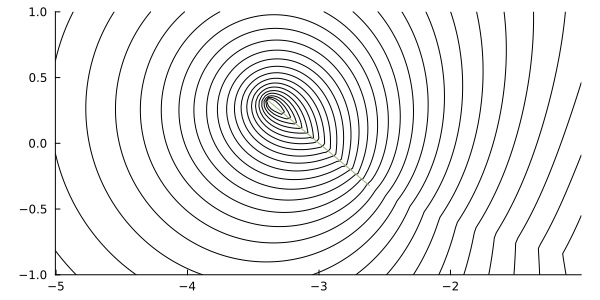

In [26]:
xg = range(xlim...,length=201)
yg = range(ylim...,length=51)
zg = [x + im*y for y in yg, x in xg]
ζg = inverse_conftransform(zg,b)
ps = streamlines(xg,yg,ζg,(b,sys),levels=range(-1,1,length=31),xlim=xlim,ylim=ylim)
plot!(ps,b,size=(600,300))

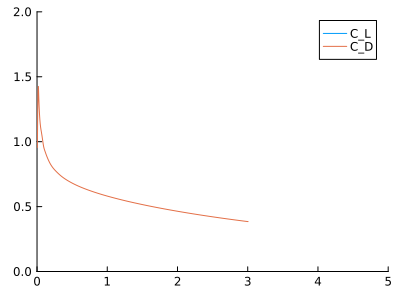

In [27]:
fhist = -diff(imp)/Δt
plot(time,2*imag.(fhist),label="C_L",xlim=(0,5),ylim=(0,2),legend=true)
plot!(time,2*real.(fhist),label="C_D")

## 40 degrees with spcrit1 = 0

In [28]:
c = 1.0
p = Polygon([-0.5c,0.5c],[0.0,0.0])
Zr = 0.0+0.0im
α = -40*π/180
b = ConformalBody(p,Zr,α)

Body generated by: Schwarz-Christoffel map of unit circle to exterior of polygon with 2 vertices

  centroid at 0.0 + 0.0im
  angle -0.6981


In [29]:
xlim=(-2,2)
ylim=(-1,1)
xg = range(xlim...,length=201)
yg = range(ylim...,length=51)
zg = [x + im*y for y in yg, x in xg]
ζg = inverse_conftransform(zg,b);

In [30]:
t = 0.0
motion = RigidBodyMotion(0.0, 0.0)
Winf = 1.0 + 0.0im
fs = Freestreams.Freestream(conj(Winf))
sys = (fs,)
sys = inverse_conftransform(sys,b)

clear_images!(b)
enforce_no_flow_through!(b, motion, sys, t)

function compute_ẋ!(ẋ, x, t)
    body, ambient_sys = x
    motion = ẋ[1]
    # update the instantaneous motion of the body with the current motion
    motion.ċ, motion.c̈, motion.α̇, motion.α̈ = motion.kin(t)

    enforce_no_flow_through!(body, motion, ambient_sys, t)

    # Zero the velocity
    reset_velocity!(ẋ, x)

    # Compute the self-induced velocity of the system
    self_induce_velocity!(ẋ, x, t)

    # Modify the velocity so that it provides the rate of change in the circle plane.
    transform_velocity!(ẋ, ẋ, x, body)
end

function shed_new_vorticity!(blobs, edge1, edge2, body, motion, t, spcrit1 = 0.0, spcrit2 = 0.0)
    # edge1 and edge2 specify the indices of edge points on the body

    ϕ = 1/3 # fractional distance from the edge point to the previous blob

    # Location edges in physical plane
    zedge1 = body.zs[edge1]
    zedge2 = body.zs[edge2]

    # positions of previously-released blobs, transformed to physical plane
    zblob1 = conftransform(blobs[end-1].z,body)
    zblob2 = conftransform(blobs[end].z,body)

    # positions of new blobs in physical plane
    z1 = ϕ*zblob1 + (1-ϕ)*zedge1
    z2 = ϕ*zblob2 + (1-ϕ)*zedge2

    # positions of new blobs in circle plane
    ζ1 = inverse_conftransform(z1,body)
    ζ2 = inverse_conftransform(z2,body)

    # new blobs, with unit strength for now
    blob1 = Vortex.Blob(ζ1, 1.0, δ)
    blob2 = Vortex.Blob(ζ2, 1.0, δ)

    enforce_no_flow_through!(body, motion, blobs, t)

    # Determine the strengths of the new blobs
    Γ1, Γ2 = Bodies.vorticity_flux(body, edge1, edge2, (body,blobs), [blob1], [blob2], t, spcrit1, spcrit2);

    # Add the new blobs to the list
    push!(blobs, Vortex.Blob(ζ1, Γ1, blobs[1].δ), Vortex.Blob(ζ2, Γ2, blobs[1].δ))

end

Δt = 5e-3
b = ConformalBody(p,Zr,α)
Żr = -1.0 + 0.0im
motion = RigidBodyMotion(Żr,0.0)


# critical edge suction parameters
spcrit1 = 0 # leading edge. Make this Inf if you want to suppress vortex shedding from the leading edge.
spcrit2 = 0 # trailing edge

kLE, kTE = 1, 2

# Nothing to change below this line

# blob radius
δ = 0.02

# locations of edges in physical plane
zedge1, zedge2 = b.zs[[kLE,kTE]]

# Vector to add to these edges. This determines the initial placement of the
# first vortex elements relative to the edges.
# Δz₀ = -3*im*Δt*exp(-im*b.α)
Δz₀ = [-3*Δt*exp(im*b.α),3*Δt*exp(im*b.α)]


# locations of initial blobs in circle plane
ζblob = inverse_conftransform(Δz₀ .+ [zedge1, zedge2],b)

# create the initial two blobs, for now with unit strength
blobs = Vortex.Blob.(ζblob, 1.0, δ)

enforce_no_flow_through!(b, motion, (), 0.0)
sys = (b,)

# This determines the circulations that enforce the edge conditions
Γ1, Γ2 = Bodies.vorticity_flux(b, kLE, kTE, sys, [blobs[1]], [blobs[2]], 0, spcrit1, spcrit2);

# Now create the blobs with the correct circulations
blobs = Vortex.Blob.(ζblob, [Γ1, Γ2], δ)

# This creates the image blobs, so that no-penetration condition is enforced
enforce_no_flow_through!(b, motion, blobs, 0.0)

# Set up the initial system
ambient_sys = blobs

t = 0.0
sys = (b, ambient_sys)
sys₊ = deepcopy(sys) # Used for storage during time-marching
nothing

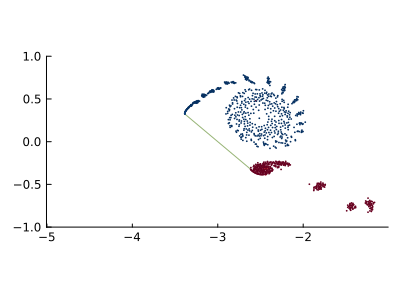

In [31]:
ẋs = (motion, allocate_velocity(ambient_sys))
time = Float64[]
imp = ComplexF64[]
blob_z = conftransform(ambient_sys,b)
track = [deepcopy((b,blob_z))]
push!(imp,Elements.impulse((b,blob_z)))
tsamp = 0.25 # Rate at which to save system data in `track` array
nothing

tf = 3.0
for tloc in 0:Δt:tf
    b_now, ambient_ω_ζ = sys

    resize!(sys₊[2], length(sys[2]))
    TimeMarching.forward_euler!(sys₊, sys, t, Δt, compute_ẋ!, advect!, ẋs)

    global sys₊, sys = sys, sys₊

    global t += Δt

    shed_new_vorticity!(sys[2], kLE, kTE, sys[1], ẋs[1], t, spcrit1, spcrit2)

    # save stuff
    push!(time,t)
    b_now, ambient_ω_ζ = deepcopy(sys)
    global blob_z = conftransform(ambient_ω_ζ,b_now)

    if abs(mod(t,tsamp))<1e-8 || abs(mod(t,tsamp)-tsamp)<1e-8
        push!(track,deepcopy((b_now,blob_z)))
    end

    enforce_no_flow_through!(b_now, motion, ambient_ω_ζ, t)
    push!(imp,Elements.impulse((b_now,blob_z)))

end
b_now, ambient_ω_ζ = sys
blob_z = conftransform(ambient_ω_ζ,b_now);

xlim = (-2-time[end],2-time[end])
ylim = (-1,1)
ps = plot(track[end],legend=false,markerstrokewidth=0,color=cgrad(:RdBu,rev=true),clim=(-0.025/(2π),0.025/(2π)),markersize=1,ratio=1,xlim=xlim,ylim=ylim) #

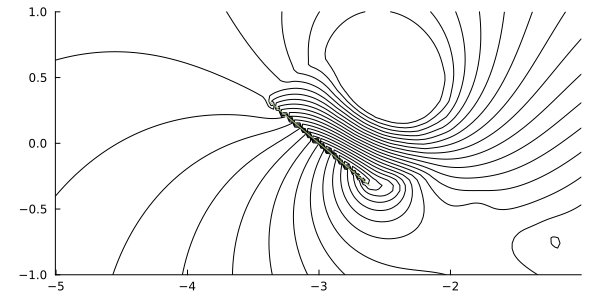

In [32]:
xg = range(xlim...,length=201)
yg = range(ylim...,length=51)
zg = [x + im*y for y in yg, x in xg]
ζg = inverse_conftransform(zg,b)
ps = streamlines(xg,yg,ζg,(b,sys),levels=range(-1,1,length=31),xlim=xlim,ylim=ylim)
plot!(ps,b,size=(600,300))

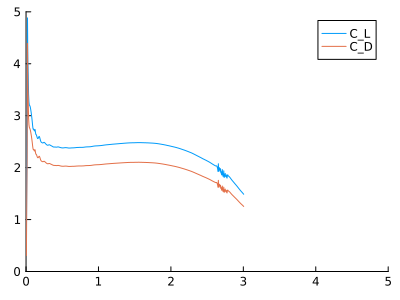

In [34]:
fhist = -diff(imp)/Δt
plot(time,2*imag.(fhist),label="C_L",xlim=(0,5),ylim=(0,5),legend=true)
plot!(time,2*real.(fhist),label="C_D")

## 4)
We can see that changing spcrit1 from Inf to 0 had a drastic impact on the results: the $C_L$ and $C_D$ plots shoot upwards to a much higher peak of roughly 5. Similarly, we can see that the vortex pattern produces a significantly different result too, where the first case with spcrit1 = Inf appeared to have circular-ish arcs around the plate. On the other hand, there appear to be two set of large primary vortices originating from either end of the plate with spcrit1 = 0. Furthermore, since $F_L\propto C_L$, this case corresponds to a larger overall force experienced by the plate.